# Exploration Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle

# import clusters
from sklearn.cluster import KMeans

# ignore warnings to reduce clutter
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = wrangle.get_spotify_top_artists_discography_data()
train, validate, test = wrangle.split_data(df)
scaler, train_scaled, validate_scaled, test_scaled = wrangle.standard_scaler(train, validate, test)

In [3]:
df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_minutes
0,51,0.217,0.208,7,-11.112,1,0.0434,0.9670,0.01080,0.2920,0.0787,206.289,3,5953200000
1,51,0.477,0.637,7,-7.244,1,0.0385,0.0560,0.01430,0.0904,0.5450,112.574,4,16150440000
2,51,0.349,0.795,11,-5.813,0,0.0693,0.0302,0.00176,0.1300,0.4460,79.704,4,13248000000
3,51,0.519,0.753,4,-5.334,1,0.0412,0.0161,0.00307,0.4480,0.3160,148.326,4,13942260000
4,51,0.478,0.262,2,-10.825,1,0.0281,0.7180,0.58500,0.2320,0.0861,132.065,4,12332340000


### Examine distributions

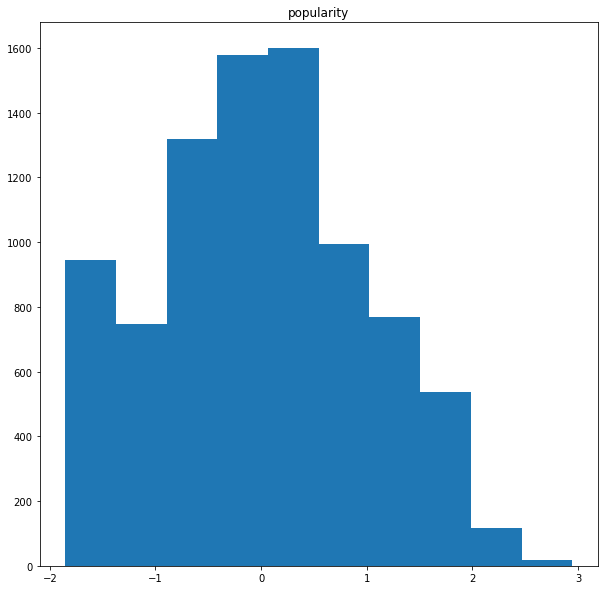

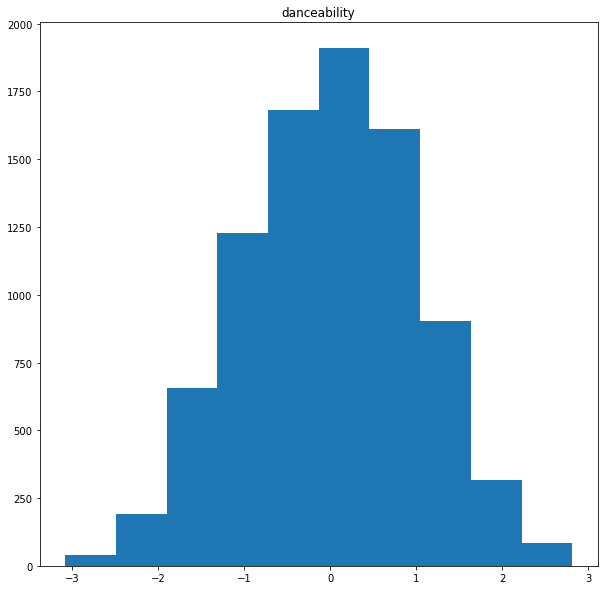

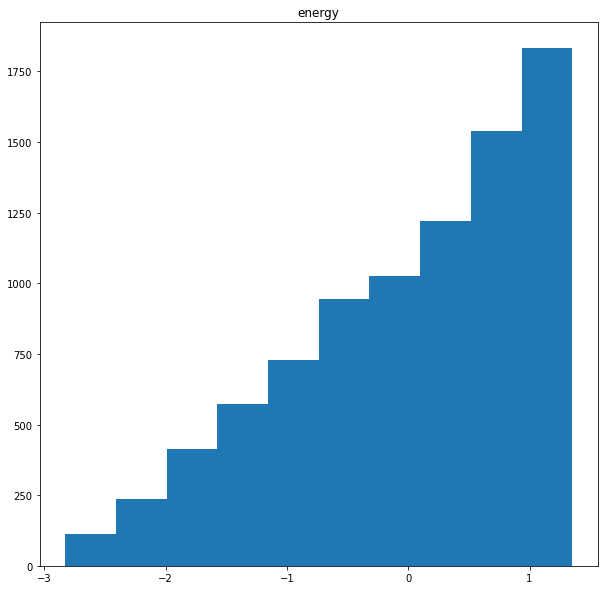

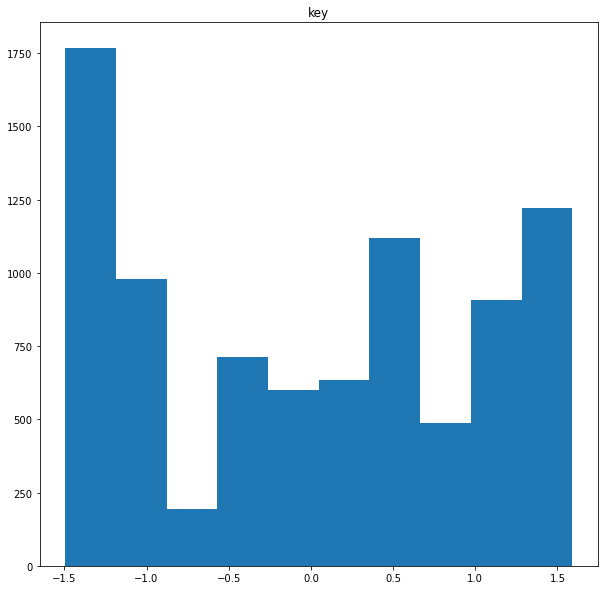

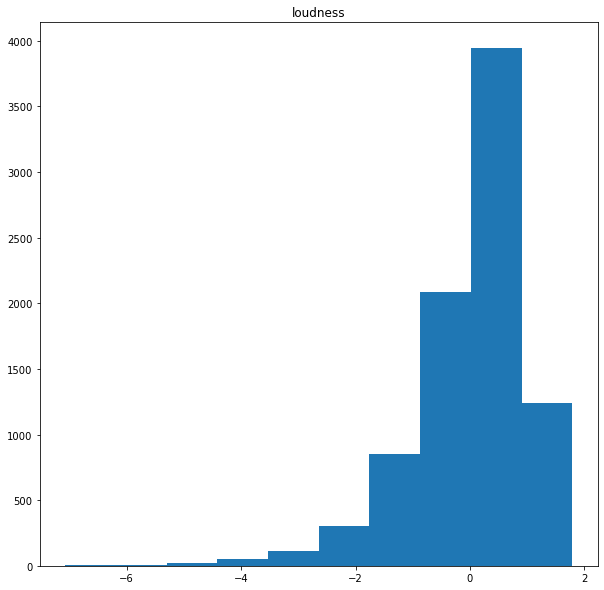

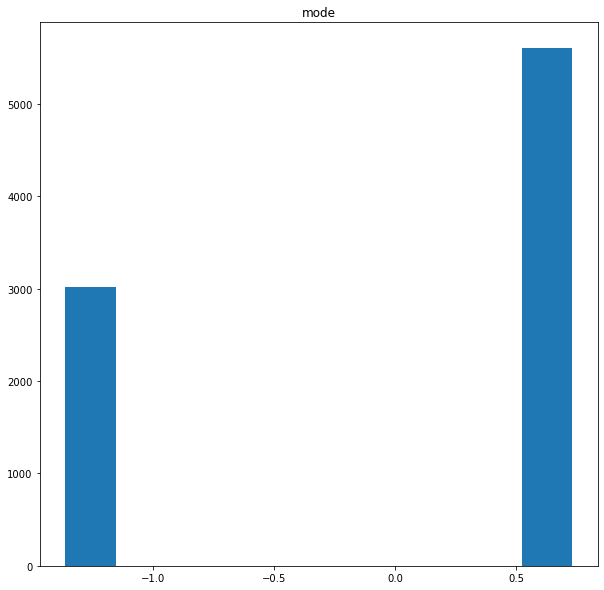

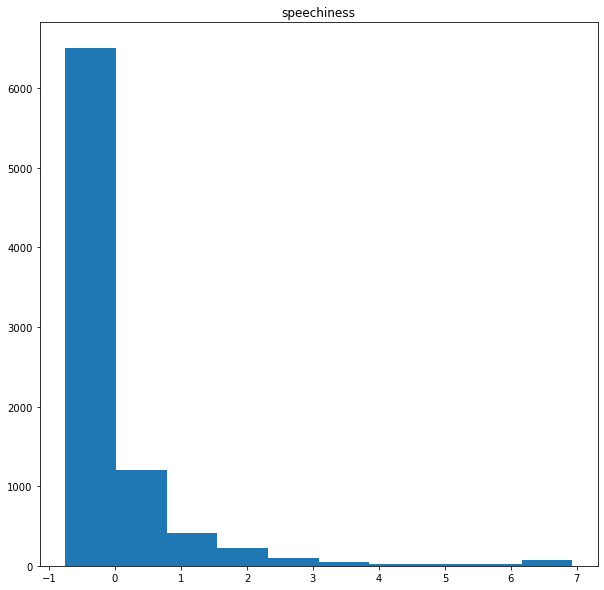

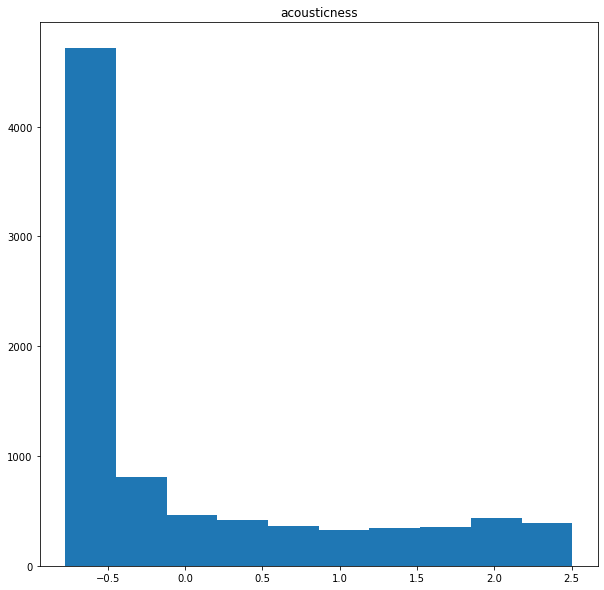

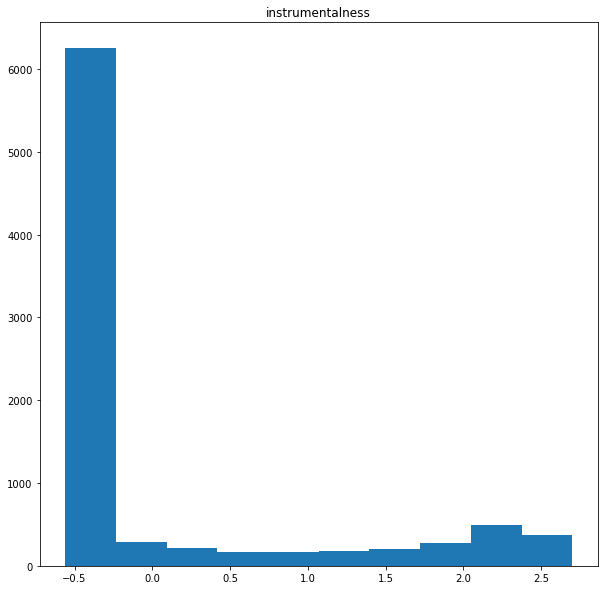

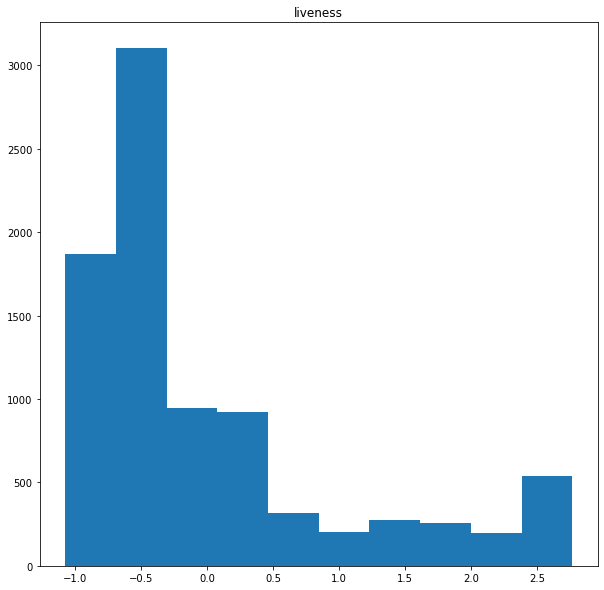

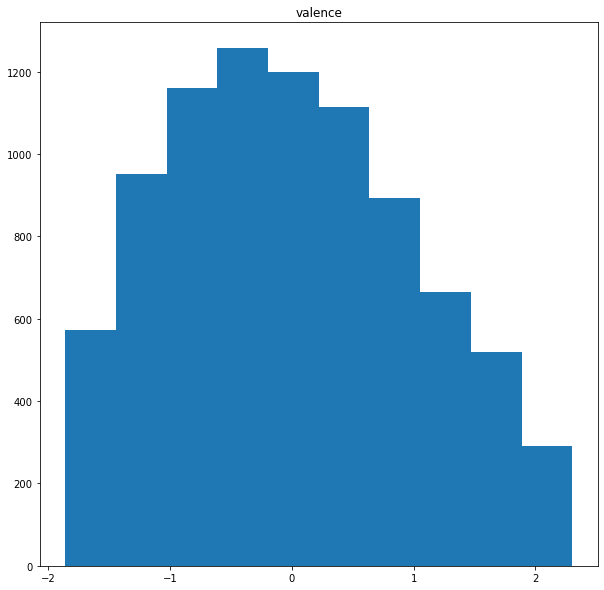

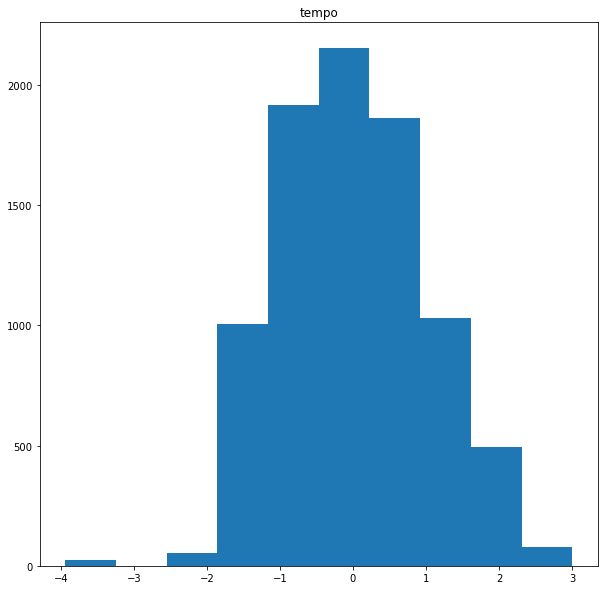

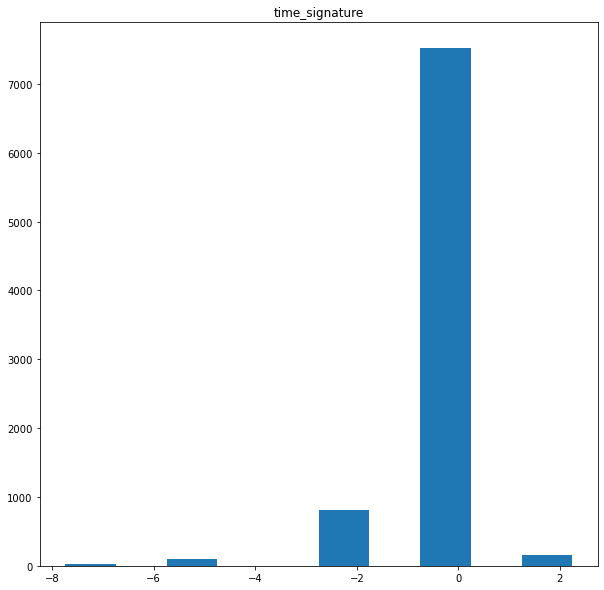

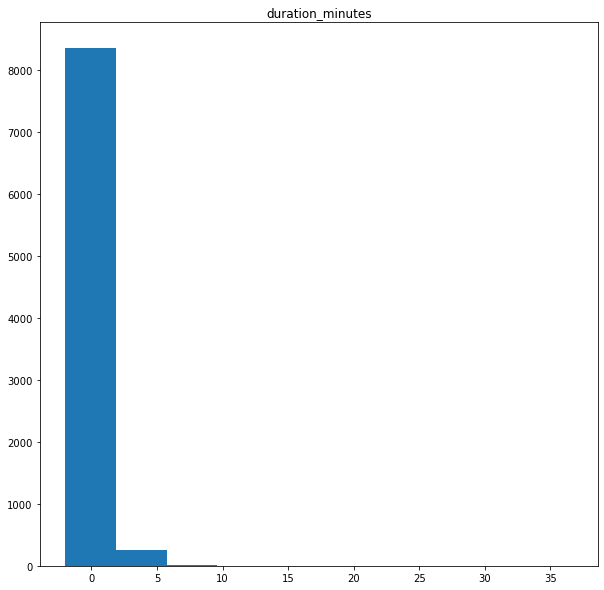

In [4]:
for col in train_scaled.columns.to_list():
    plt.figure(figsize=(10,10))
    plt.hist(train_scaled[col])
    plt.title(col)

### Check outliers

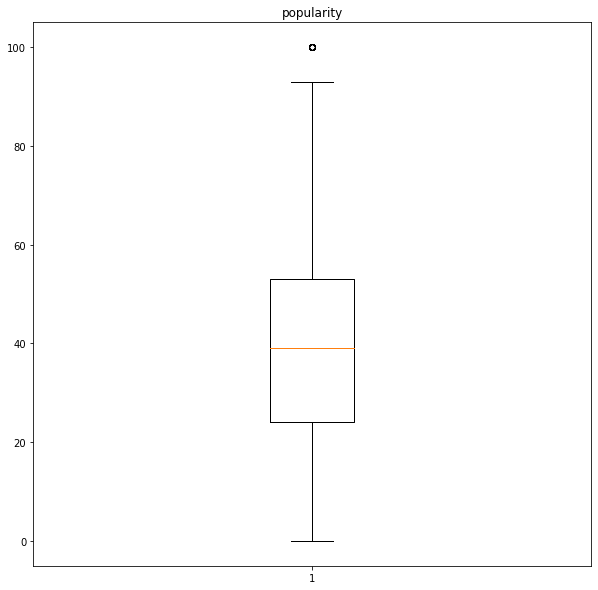

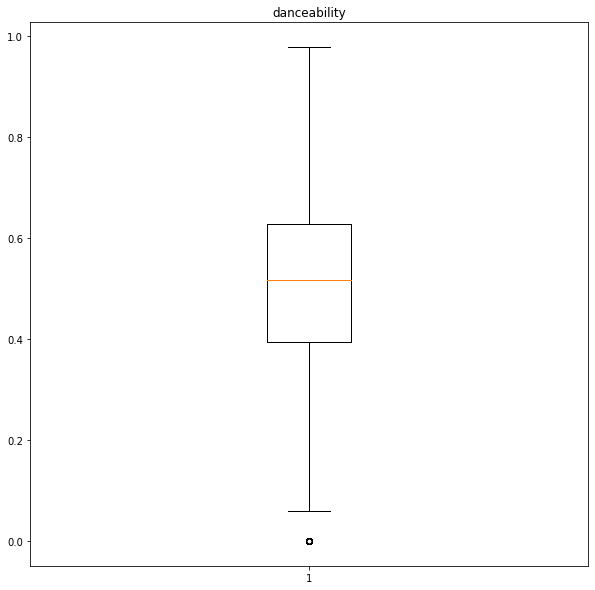

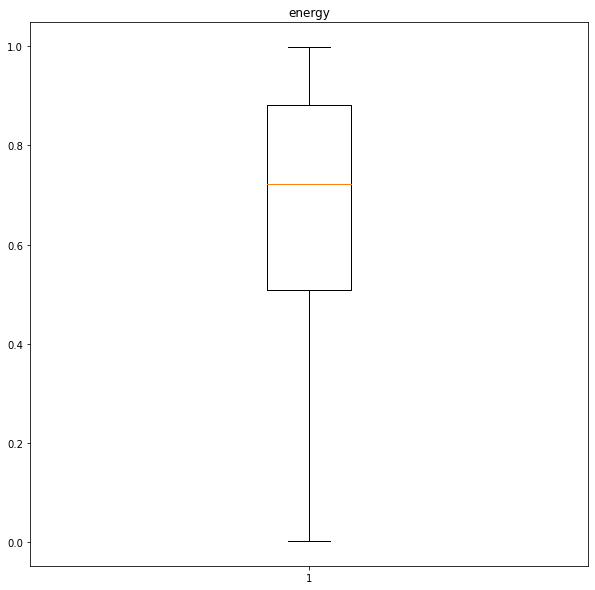

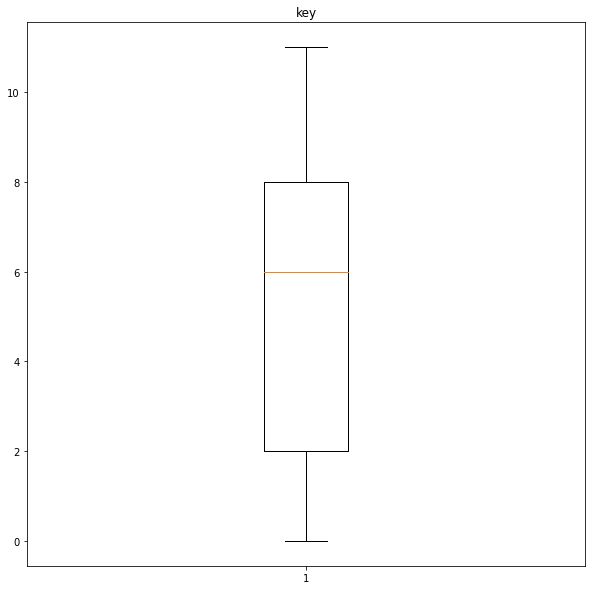

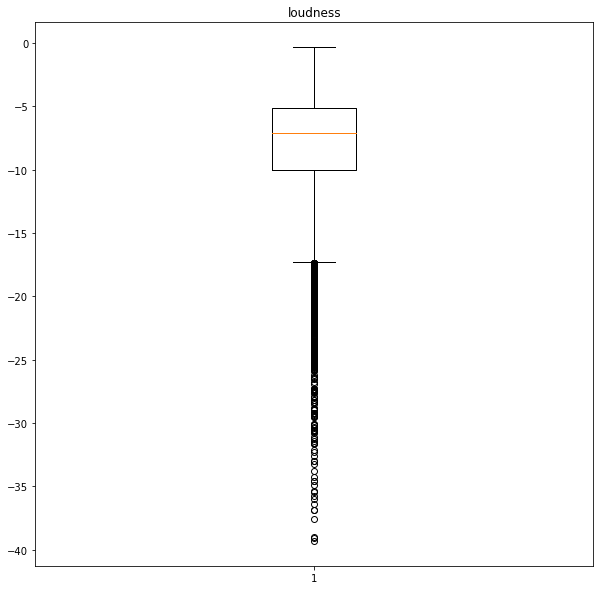

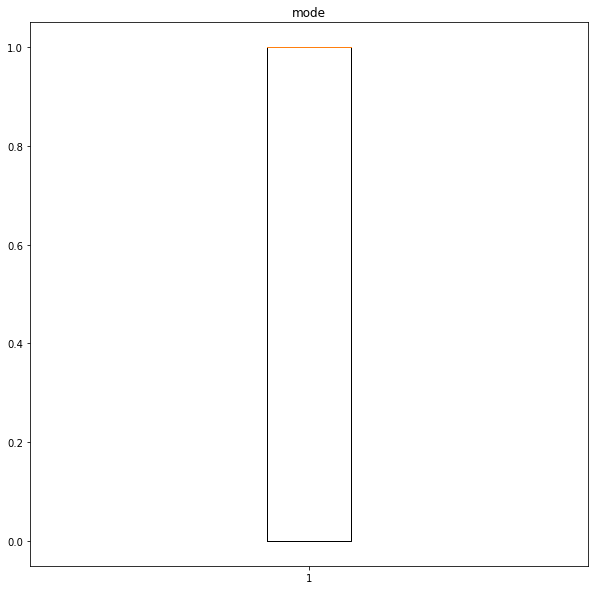

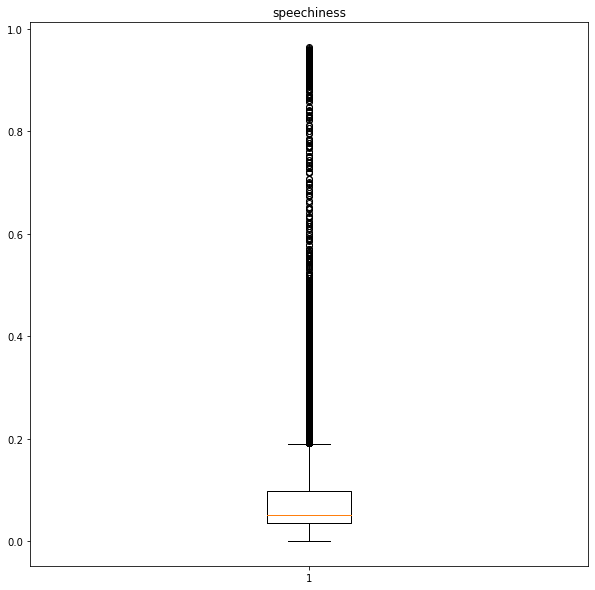

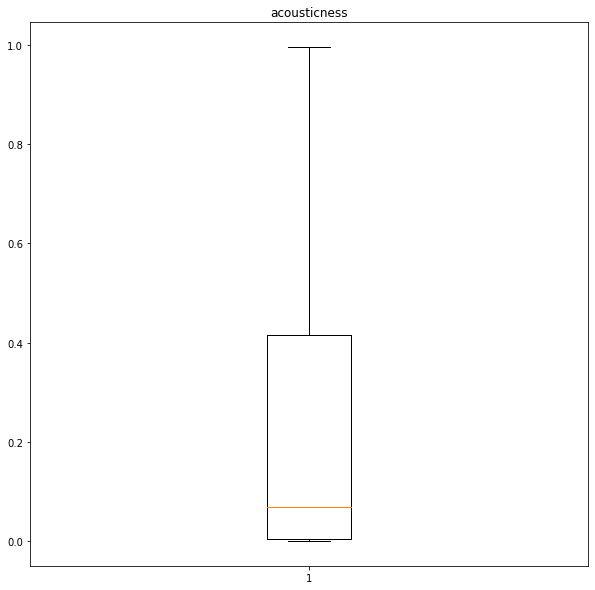

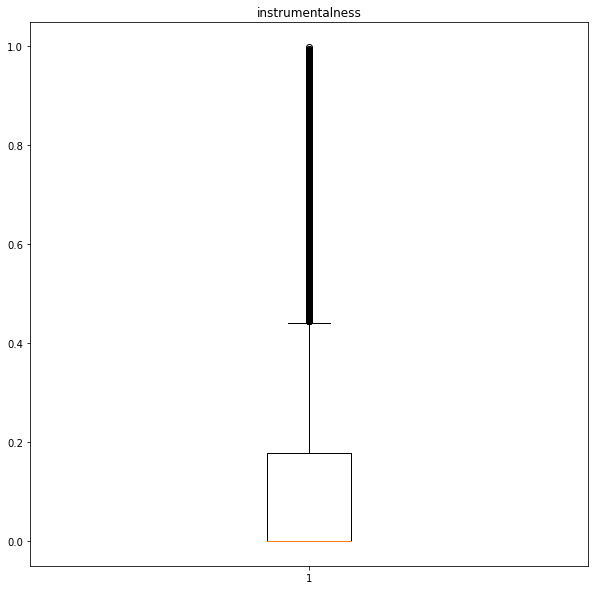

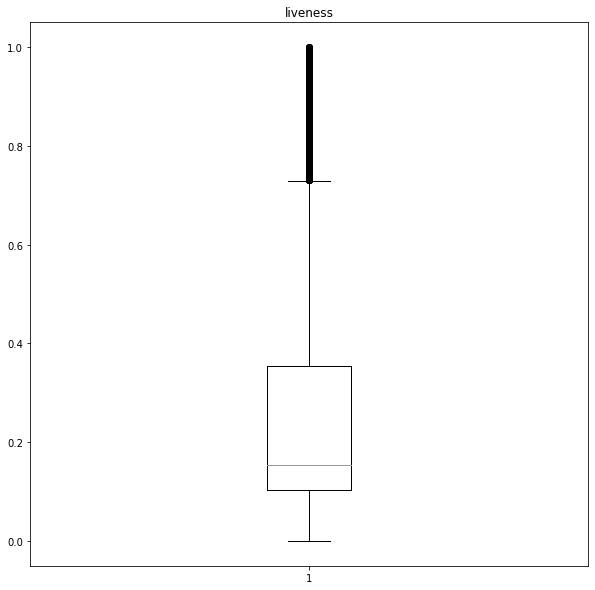

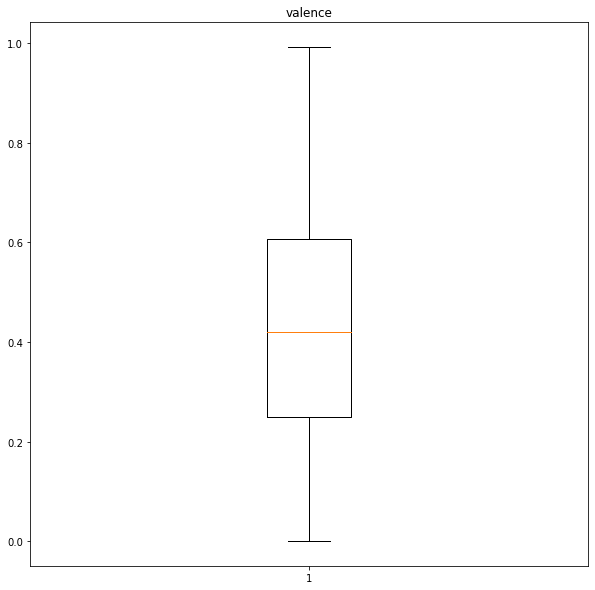

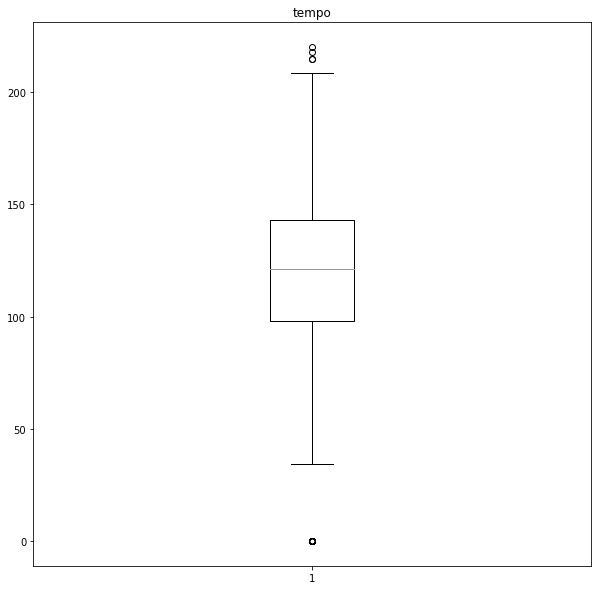

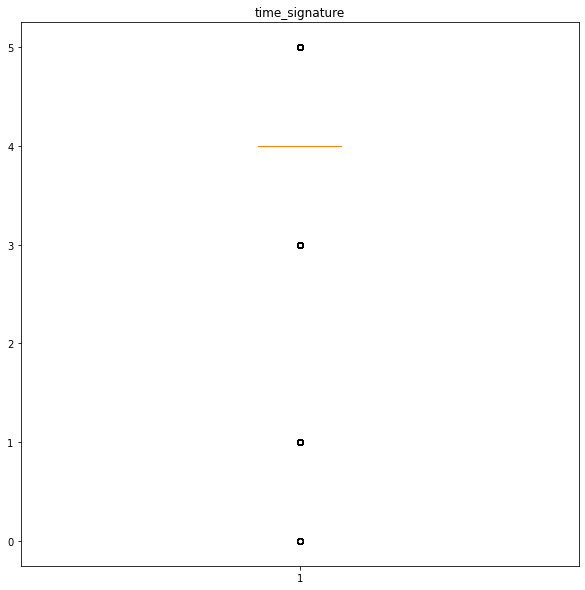

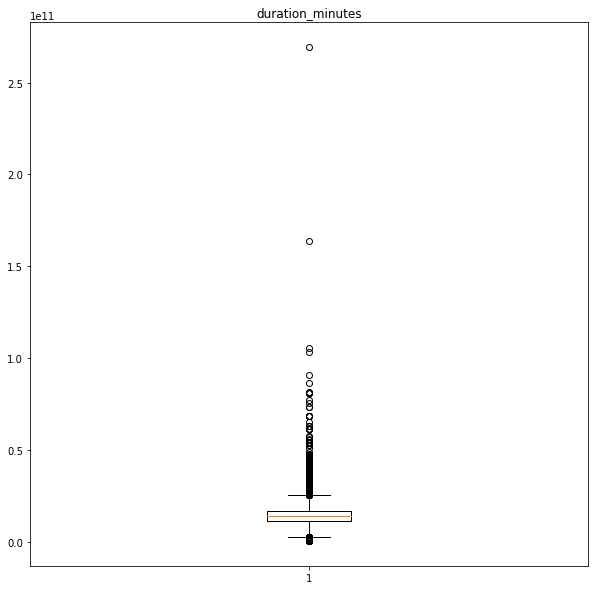

In [5]:
for col in df.columns.to_list():
    plt.figure(figsize=(10,10))
    plt.boxplot(df[col])
    plt.title(col)

Let's see what SelectKBest has to say about the audio features.

In [6]:
X_train = train.drop(columns = 'popularity')
y_train = train['popularity']

from sklearn.feature_selection import SelectKBest, f_regression

# our selecter is an f_regression stats test and retrieving 10 features
f_selector = SelectKBest(f_regression, k=10)

# find the top 5 features correlated with our target
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

f_feature

['danceability',
 'energy',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'time_signature',
 'duration_minutes']

## Check clustering options
### What clusters make sense?
beat_cluster: tempo, energy, danceability

mood_cluster: mode, key, and valence

ambience_cluster: acousticness, intrumentalness, loudness

## Beat Cluster
tempo, energy, danceability, and loudness

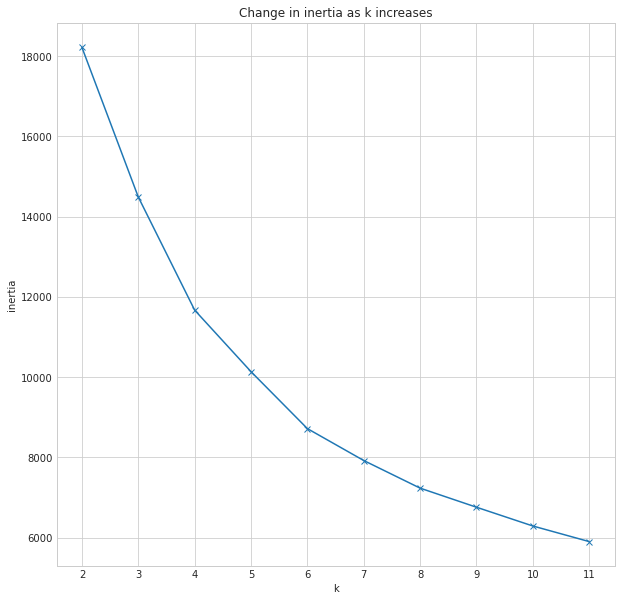

In [7]:
# define features for clustering
X_train_beat_cluster = train_scaled[['tempo','energy','danceability']]

# elbow method to find k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 10))
    pd.Series({k: KMeans(k).fit(X_train_beat_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [8]:
# create cluster features for validate and test
X_validate_beat_cluster = validate_scaled[['tempo','energy','danceability']]
X_test_beat_cluster = test_scaled[['tempo','energy','danceability']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_beat_cluster)
# use the object
train_scaled['beat_cluster'] = kmeans.predict(X_train_beat_cluster)
validate_scaled['beat_cluster'] = kmeans.predict(X_validate_beat_cluster)
test_scaled['beat_cluster'] = kmeans.predict(X_test_beat_cluster)
X_train_beat_cluster['beat_cluster'] = kmeans.predict(X_train_beat_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_beat_cluster.loc[:, X_train_beat_cluster.columns != 'beat_cluster'].columns)

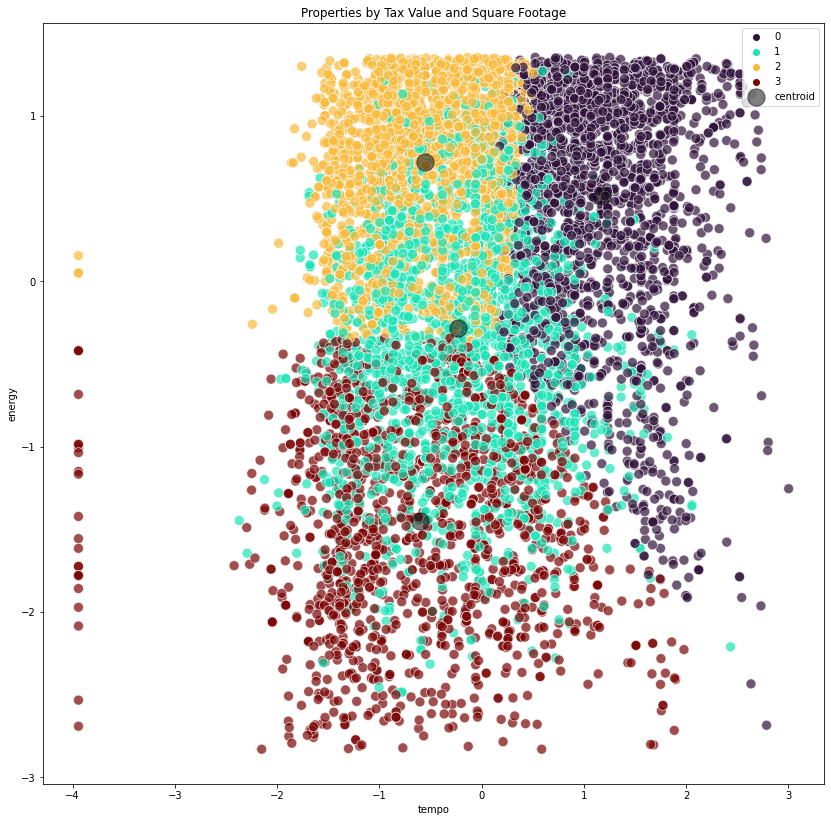

In [9]:
# visualize
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_beat_cluster.loc[:, X_train_beat_cluster.columns != 'beat_cluster'].columns)
plt.figure(figsize = (14,14))
sns.scatterplot(data = X_train_beat_cluster, x = 'tempo', y = 'energy', hue = 'beat_cluster', s = 100, alpha = 0.7, palette='turbo')
centroids.plot.scatter(x='tempo',y='energy',ax = plt.gca(), color = 'black',alpha = 0.5, s=300, label = 'centroid')
plt.title('Properties by Tax Value and Square Footage')
plt.legend(loc = 'upper right')

## Mood Cluster

mode, key, and valence


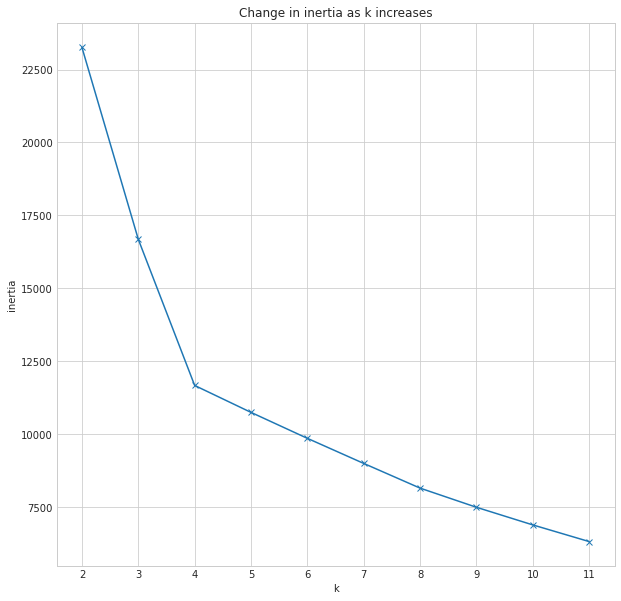

In [10]:
# define features for clustering
X_train_mood_cluster = train_scaled[['mode','key','valence']]

# elbow method to find k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 10))
    pd.Series({k: KMeans(k).fit(X_train_beat_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [11]:
# create cluster features for validate and test
X_validate_mood_cluster = validate_scaled[['mode','key','valence']]
X_test_mood_cluster = test_scaled[['mode','key','valence']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_mood_cluster)
# use the object
train_scaled['mood_cluster'] = kmeans.predict(X_train_mood_cluster)
validate_scaled['mood_cluster'] = kmeans.predict(X_validate_mood_cluster)
test_scaled['mood_cluster'] = kmeans.predict(X_test_mood_cluster)
X_train_mood_cluster['mood_cluster'] = kmeans.predict(X_train_mood_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_mood_cluster.loc[:, X_train_mood_cluster.columns != 'mood_cluster'].columns)

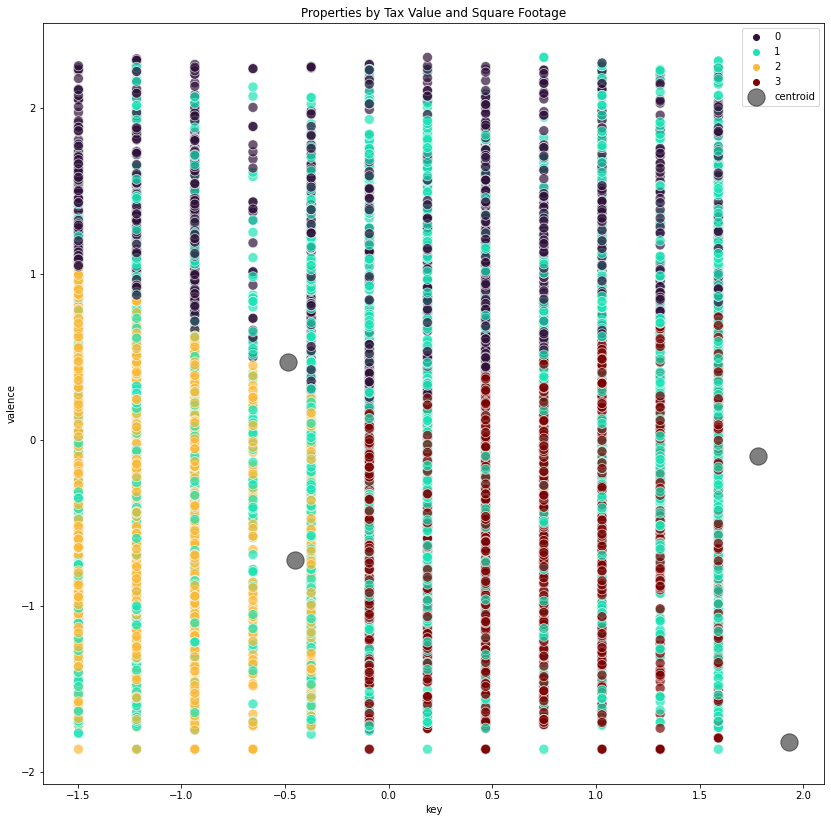

In [19]:
# visualize
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_mood_cluster.loc[:, X_train_mood_cluster.columns != 'mood_cluster'].columns)
plt.figure(figsize = (14,14))
sns.scatterplot(data = X_train_mood_cluster, x = 'key', y = 'valence', hue = 'mood_cluster', s = 100, alpha = 0.7, palette='turbo')
centroids.plot.scatter(x='key',y='valence',ax = plt.gca(), color = 'black',alpha = 0.5, s=300, label = 'centroid')
plt.title('Properties by Tax Value and Square Footage')
plt.legend(loc = 'upper right')

## Ambience Cluster
acousticness and intrumentalness

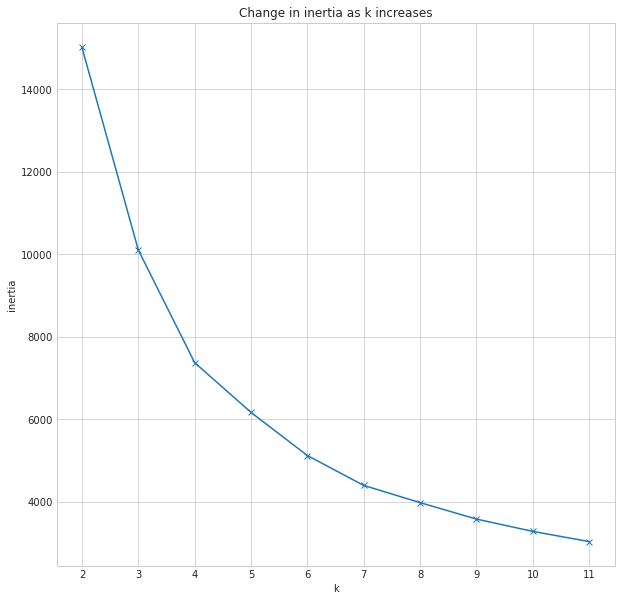

In [13]:
# define features for clustering
X_train_ambience_cluster = train_scaled[['acousticness','instrumentalness','loudness']]

# elbow method to find k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 10))
    pd.Series({k: KMeans(k).fit(X_train_ambience_cluster).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [14]:
# create cluster features for validate and test
X_validate_ambience_cluster = validate_scaled[['acousticness','instrumentalness','loudness']]
X_test_ambience_cluster = test_scaled[['acousticness','instrumentalness','loudness']]

# define cluster object
kmeans = KMeans(n_clusters=4, random_state = 222)
# fit cluster object to features
kmeans.fit(X_train_ambience_cluster)
# use the object
train_scaled['ambience_cluster'] = kmeans.predict(X_train_ambience_cluster)
validate_scaled['ambience_cluster'] = kmeans.predict(X_validate_ambience_cluster)
test_scaled['ambience_cluster'] = kmeans.predict(X_test_ambience_cluster)
X_train_ambience_cluster['ambience_cluster'] = kmeans.predict(X_train_ambience_cluster)


#define centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_ambience_cluster.loc[:, X_train_ambience_cluster.columns != 'ambience_cluster'].columns)

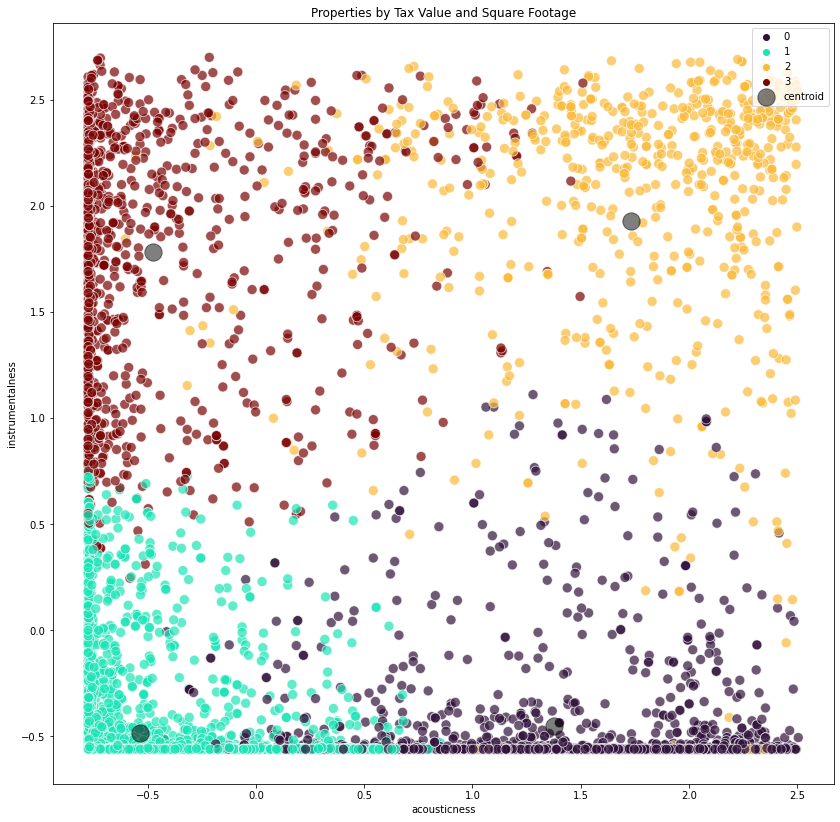

In [15]:
# visualize
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = X_train_ambience_cluster.loc[:, X_train_ambience_cluster.columns != 'ambience_cluster'].columns)
plt.figure(figsize = (14,14))
sns.scatterplot(data = X_train_ambience_cluster, x = 'acousticness', y = 'instrumentalness', hue = 'ambience_cluster', s = 100, alpha = 0.7, palette='turbo')
centroids.plot.scatter(x='acousticness',y='instrumentalness',ax = plt.gca(), color = 'black',alpha = 0.5, s=300, label = 'centroid')
plt.title('Properties by Tax Value and Square Footage')
plt.legend(loc = 'upper right')

In [16]:
X_train = train_scaled.drop(columns = 'popularity')
y_train = train_scaled['popularity']

from sklearn.feature_selection import SelectKBest, f_regression

# our selecter is an f_regression stats test and retrieving 10 features
f_selector = SelectKBest(f_regression, k=10)

# find the top 5 features correlated with our target
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()

f_feature

['danceability',
 'energy',
 'loudness',
 'mode',
 'instrumentalness',
 'liveness',
 'time_signature',
 'duration_minutes',
 'beat_cluster',
 'ambience_cluster']

## Clustering Summary

The mood clusters has too much overlap to be useful, I expect this is because the features included are mostly categorical in nature.

The beat and ambience clusters have a pretty distinct split and even appeared on SelectKBest, I'll run statistical tests and visualize the clusters with popularity in the next section.

# Statistical Tests

Finding correlation between audio features and popularity

In [17]:
# Create X and y for train, validate, test and their scaled versions.
X_train = train.drop(columns=['artist','song','album','popularity'])
y_train = train['popularity']

X_validate = validate.drop(columns=['artist','song','album','popularity'])
y_validate = validate['popularity']

X_test = test.drop(columns=['artist','song','album','popularity'])
y_test = test['popularity']

X_train_scaled = train_scaled.drop(columns=['popularity'])
y_train_scaled = train_scaled['popularity']

X_validate_scaled = validate_scaled.drop(columns=['popularity'])
y_validate_scaled = validate_scaled['popularity']

X_test_scaled = test_scaled.drop(columns=['popularity'])
y_test_scaled = test_scaled['popularity']

KeyError: "['artist' 'song' 'album'] not found in axis"